In [91]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from statsmodels.formula.api import ols
import statsmodels.api as sm
import missingno as mno
%matplotlib inline
import seaborn as sns
sns.set() 
plt.rcParams["figure.figsize"] = (20,10)

# Setup display options of the notebook
#pd.set_option('display.max_row', 200)
pd.set_option('display.max_column', 111)

In [39]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [40]:
os.chdir("/content/drive/MyDrive/ML_model_deployment_streamlit")

In [41]:
ls

app.ipynb
app.py
classifier.pkl
output.csv
predict_loan_streamlit_deployment.ipynb
sample_submission_49d68Cx.csv
SessionState.py
SessionState.py.gdoc
test_lAUu6dG.csv
Test_predict_loan_streamlit_deployment.ipynb
train_ctrUa4K.csv


## **Contexte du projet** : **Automatisation de la prévision des prêts**
Automatisez le processus d'éligibilité au prêt en fonction des détails du client fournis lors du remplissage du formulaire de demande en ligne )

#### **Générer hypothéses** : Pour commencer, voici quelques facteurs qui, à mon avis, nous seront utiles dans le cadre de ce projet :

 - **Montant du prêt** : Le montant total du prêt appliqué par le client. Mon hypothèse ici est que plus le montant du prêt est élevé, plus les chances d'approbation du prêt seront faibles et vice versa.
 - **Revenu du demandeur** : Le revenu du demandeur (client) peut également être un facteur déterminant. Un revenu plus élevé entraînera une probabilité plus élevée d'approbation de prêt.
 - **Éducation du demandeur** : Le niveau d'études du demandeur peut également être un facteur essentiel pour prédire le statut de prêt d'un client. Mon hypothèse est que si le niveau d'études du demandeur est plus élevé, les chances d'approbation de son prêt seront plus élevées.

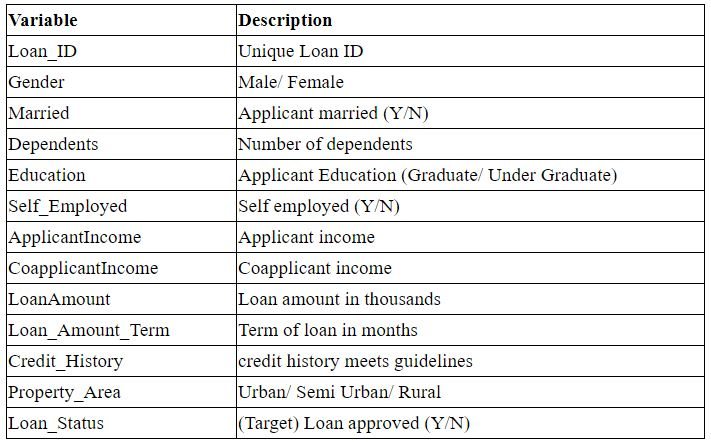

### Loading Data

In [173]:
df = pd.read_csv('./train_ctrUa4K.csv') 
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [174]:
df.shape

(614, 13)

In [175]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [177]:
df.describe(include ="O")

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,601,611,599,614,582,614,614
unique,614,2,2,4,2,2,3,2
top,LP001900,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,489,398,345,480,500,233,422


In [178]:
df[df['Loan_Status']=="Y"]["Property_Area"].value_counts()

Semiurban    179
Urban        133
Rural        110
Name: Property_Area, dtype: int64

In [179]:
df[df['Loan_Status']=="Y"]["Education"].value_counts()

Graduate        340
Not Graduate     82
Name: Education, dtype: int64

In [180]:
df[df['Loan_Status']=="Y"]["Married"].value_counts()

Yes    285
No     134
Name: Married, dtype: int64

On voit que la majorité des personnes à qui on accorde **des prêts** sont la plupart des **hommes** ,**mariés**, **gradués**, **salariés** et vivant en **semi-urban**.

In [181]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


## Analyzis and Data prep
 - Analyse univariée
 - Analyse bivariée
 - Traitement de la valeur manquante
 - Traitement des valeurs aberrantes
 - Ingénierie des fonctionnalités

In [182]:
df['Gender']= df['Gender'].map({'Male':1, 'Female':0})
df['Married']= df['Married'].map({'Yes':1, 'No':0})
df['Loan_Status']= df['Loan_Status'].map({'Y':1, 'N':0})

In [183]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

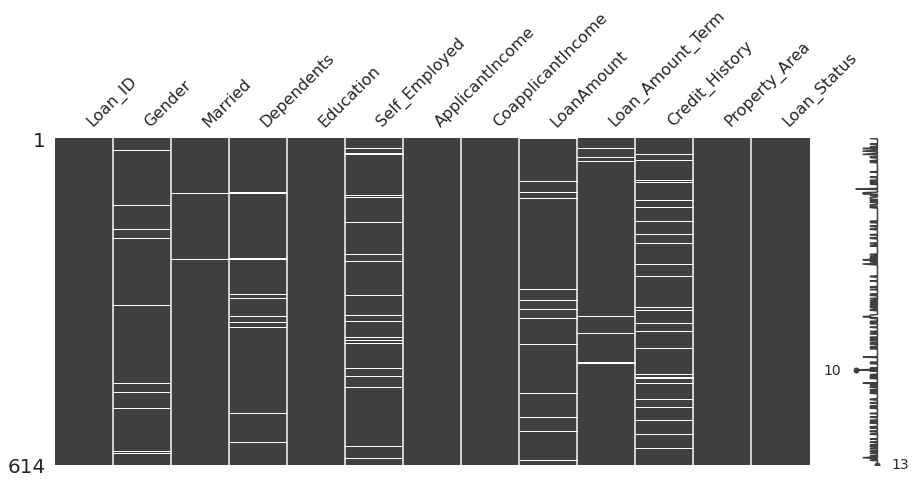

In [184]:
mno.matrix(df, figsize = (15, 6))

In [185]:
for i in (df.columns):
    # count number of rows with missing values
    n_miss = df[i].isnull().sum()
    perc = n_miss / df.shape[0] * 100
    
    print('> {}, Missing: {}  total {} %' .format (i, n_miss, perc))

> Loan_ID, Missing: 0  total 0.0 %
> Gender, Missing: 13  total 2.1172638436482085 %
> Married, Missing: 3  total 0.4885993485342019 %
> Dependents, Missing: 15  total 2.44299674267101 %
> Education, Missing: 0  total 0.0 %
> Self_Employed, Missing: 32  total 5.211726384364821 %
> ApplicantIncome, Missing: 0  total 0.0 %
> CoapplicantIncome, Missing: 0  total 0.0 %
> LoanAmount, Missing: 22  total 3.5830618892508146 %
> Loan_Amount_Term, Missing: 14  total 2.2801302931596092 %
> Credit_History, Missing: 50  total 8.143322475570033 %
> Property_Area, Missing: 0  total 0.0 %
> Loan_Status, Missing: 0  total 0.0 %


In [186]:
missing_values_count = df.isnull().sum()
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

print('The number of missing values of all rows in the dataset',(total_missing/total_cells)*100)

The number of missing values of all rows in the dataset 1.8667000751691305


Vu que seulement 2% des données sont manquantes, on les supprimera pour la suite.

In [187]:
df.dropna(inplace =True)
df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [188]:
df.shape

(480, 13)

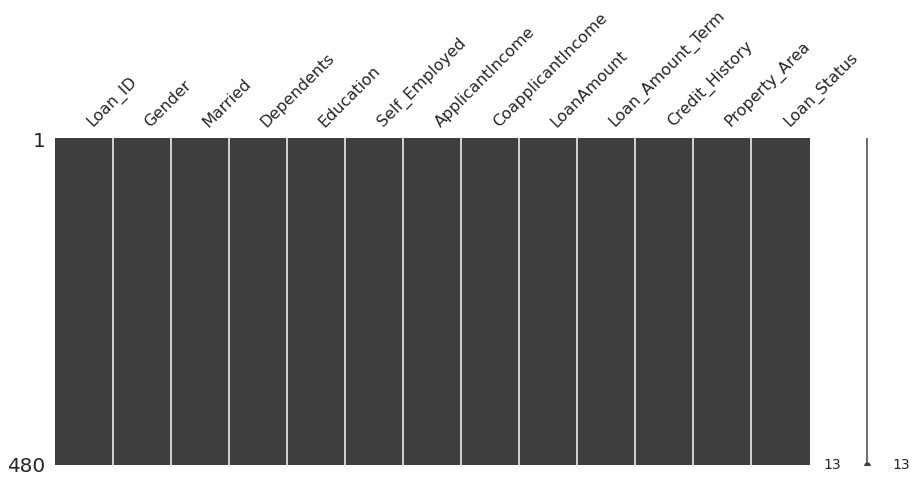

In [189]:
#dropna function in Pandas removes all the rows with missing values

mno.matrix(df, figsize = (15, 6))

### Lorsque nous parlons de corrélation, il est facile d'avoir un premier aperçu avec une carte thermique :

In [190]:
#plt.figure(figsize=(8,6))
# cor = df.corr()
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.show()

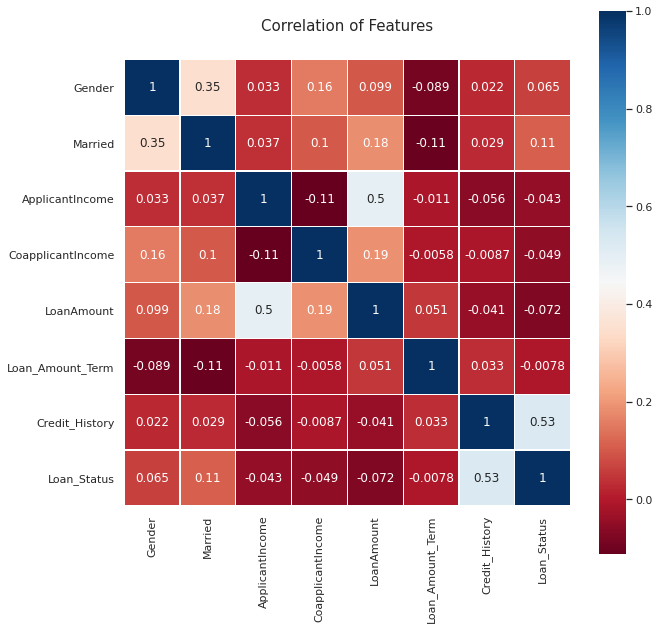

In [191]:
colormap = plt.cm.RdBu
plt.figure(figsize=(10,10))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

### Corrélations avec la variable de sortie :
- Pour avoir une idée des variables pouvant être importées pour notre modèle 

In [192]:
#threshold = 0.5
threshold = 0.4


cor_criterion = abs(df.corr()["Loan_Status"])

relevant_features = cor_criterion[cor_criterion>threshold]
relevant_features = relevant_features.reset_index()
relevant_features.columns = ['Variables', 'Correlation']
relevant_features = relevant_features.sort_values(by='Correlation', ascending=False)
relevant_features

,Variables,Correlation
1,Loan_Status,1.00000
0,Credit_History,0.52939


 ### Identification des caractéristiques fortement corrélées (Nombre de colonnes dans l'ensemble de données avec une valeur de corrélation supérieure à 0,9 avec au moins 1 autre colonne)
  - Une hypothèse du modèle de l'analyse de régression linéaire est d'éviter la multicolinéarité. Cette fonction consiste à trouver des corrélations élevées :

#### 1ére Méthode:

In [193]:
#Step - Creating the Correlation matrix and Selecting the Upper trigular matrix
#So now we are creating a square matrix with dimensions equal to the number of features.
#In which we will have the elements as the absolute value of correlation between the features.

cor_matrix = df.corr().abs()
print(cor_matrix)

                     Gender   Married  ApplicantIncome  CoapplicantIncome  \
Gender             1.000000  0.349424         0.032644           0.156171   
Married            0.349424  1.000000         0.036717           0.102950   
ApplicantIncome    0.032644  0.036717         1.000000           0.112588   
CoapplicantIncome  0.156171  0.102950         0.112588           1.000000   
LoanAmount         0.098975  0.183442         0.495310           0.190740   
Loan_Amount_Term   0.088704  0.107504         0.010838           0.005775   
Credit_History     0.022447  0.029095         0.056152           0.008692   
Loan_Status        0.064504  0.112321         0.043152           0.049020   

                   LoanAmount  Loan_Amount_Term  Credit_History  Loan_Status  
Gender               0.098975          0.088704        0.022447     0.064504  
Married              0.183442          0.107504        0.029095     0.112321  
ApplicantIncome      0.495310          0.010838        0.056152     0

In [194]:
#Note that Correlation matrix will be mirror image about the diagonal and all the diagonal elements will be 1. 
#So, It does not matter that we select the upper triangular or lower triangular part of the correlation matrix but we should not include the diagonal elements.
#So we are selecting the upper traingular.
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
print(upper_tri)

                   Gender   Married  ApplicantIncome  CoapplicantIncome  \
Gender                NaN  0.349424         0.032644           0.156171   
Married               NaN       NaN         0.036717           0.102950   
ApplicantIncome       NaN       NaN              NaN           0.112588   
CoapplicantIncome     NaN       NaN              NaN                NaN   
LoanAmount            NaN       NaN              NaN                NaN   
Loan_Amount_Term      NaN       NaN              NaN                NaN   
Credit_History        NaN       NaN              NaN                NaN   
Loan_Status           NaN       NaN              NaN                NaN   

                   LoanAmount  Loan_Amount_Term  Credit_History  Loan_Status  
Gender               0.098975          0.088704        0.022447     0.064504  
Married              0.183442          0.107504        0.029095     0.112321  
ApplicantIncome      0.495310          0.010838        0.056152     0.043152  
Coapplic

In [195]:
#Step - Droping the column with high correlation
#So we are selecting the columns which are having absolute correlation greater than 0.95 and making a list of those columns named 'to_drop'.

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.4)]
print(to_drop)

#Now we are droping the columns which are in the list 'to_drop' from the dataframe

#df1 = df.drop(df.columns[to_drop], axis=1)
#print(df1.head())

['LoanAmount', 'Loan_Status']


#### 2eme Méthode:

Feature Selection : how to drop features using pearson correlation

In [196]:
## with the following function we can select highly correlated features
## it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold) :
  correlated_features = set() ## set of all the names of correlated columns
  correlation_matrix = dataset.corr()
  for i in range(len(correlation_matrix.columns)) :
    for j in range(i):
      if (abs(correlation_matrix.iloc[i,j]) > threshold) : ## we are interested in abs coeff value
        colname = correlation_matrix.columns[i]  ## getting the name of the column
        correlated_features.add(colname)
  return correlated_features

In [197]:
correlation(df,0.4)

{'LoanAmount', 'Loan_Status'}

#### 3éme Méthode:

In [198]:
## Avec l'extrait suivant, nous sélectionnons simplement des variables numériques :

num_col = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = list(df.select_dtypes(include=num_col).columns)
df_data_num = df[numerical_columns]

In [199]:
# threshold = 0.8
threshold = 0.4

def high_cor_function(df):
    cor = df.corr()
    corrm = np.corrcoef(df.transpose())
    corr = corrm - np.diagflat(corrm.diagonal())
    print("max corr:",corr.max(), ", min corr: ", corr.min())
    c1 = cor.stack().sort_values(ascending=False).drop_duplicates()
    high_cor = c1[c1.values!=1]    
    thresh = threshold 
    display(high_cor[high_cor>thresh])

In [200]:
df1 = df_data_num.drop('Loan_Status',axis=1)
high_cor_function(df1)

max corr: 0.49530958608655307 , min corr:  -0.11258796933156673


ApplicantIncome  LoanAmount    0.49531
dtype: float64

In [201]:
df_data_num.columns

Index(['Gender', 'Married', 'ApplicantIncome', 'CoapplicantIncome',
       'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Loan_Status'],
      dtype='object')

On en déduit que dans l'ensemble de données, seules les colonnes **ApplicantIncomeavec** et le **LoanAmount** sont corrélées de plus de 0.4.








#### Correlation entre les variables categoricielles et la cible Loan status : 

In [202]:
obj_cols = ['Dependents', 'Education', 'Self_Employed',
       'Property_Area', 'Loan_Status']


#use chisquared test to test the dependency between the loan_status and other categorical variables
chisquare_df = pd.DataFrame([], columns=obj_cols, index = obj_cols)

for i in obj_cols:
    for j in obj_cols:
        cont = pd.crosstab(df[i], df[j])
        chisquare_df.loc[i,j] = chi2_contingency(cont)[1]        

chisquare_df

,Dependents,Education,Self_Employed,Property_Area,Loan_Status
Dependents,1.75835e-304,0.886722,0.201808,0.0535204,0.40721
Education,0.886722,4.73023e-105,0.957225,0.332869,0.168724
Self_Employed,0.201808,0.957225,1.43395e-104,0.502958,0.537194
Property_Area,0.0535204,0.332869,0.502958,1.66262e-206,0.00221396
Loan_Status,0.40721,0.168724,0.537194,0.00221396,2.2263e-105


- **Credit_History** a une meileure correlation avec la cible Loan status.

> Correlation entre les variables numériques et categoricielles avec la méthode d'Anova

In [203]:
#use one way anova to find the realtion between the object type and the float or int type
num_cols1 = df.select_dtypes('float64').columns
num_cols2 = df.select_dtypes('int64').columns

num_cols = num_cols1.append(num_cols2)

In [204]:
#use one way anova to test the relation between the numeric and categorical variable
anova_df = pd.DataFrame([], columns=obj_cols, index = num_cols)

for i in num_cols:
    for j in obj_cols:
        model = ols(i+' ~ C('+j+')', df).fit()
        anova_df.loc[i,j] = sm.stats.anova_lm(model,typ=1).iloc[0]['PR(>F)']

In [205]:
anova_df

,Dependents,Education,Self_Employed,Property_Area,Loan_Status
Gender,2.12667e-05,0.195064,0.951897,0.0591182,0.158244
Married,1.86279e-19,0.971203,0.731949,0.676183,0.0138085
CoapplicantIncome,0.902559,0.103061,0.973699,0.974227,0.283806
LoanAmount,0.00065683,0.000142268,0.00828278,0.0542275,0.116428
Loan_Amount_Term,0.0294531,0.0251947,0.446172,0.359671,0.8647
Credit_History,0.501971,0.215335,0.606494,0.596505,5.03319e-36
ApplicantIncome,0.00245326,0.00399201,0.000170181,0.509118,0.345487
Loan_Status,0.409193,0.134333,0.447966,0.00212609,0


On voit que :
 - Loan_Status a une correlation faible ApplicantIncome et Loan_Amount_Term.
 - Loan_Status a une correlation moderée avec Married,Gender,CoapplicantIncome et LoanAmount.
 - Loan_Staus a une meilleure correlation avec Credit_History(ce qui condfirms mes resultats ci-dessous)

#### Voir la relation entre prêt et loan_amount_term

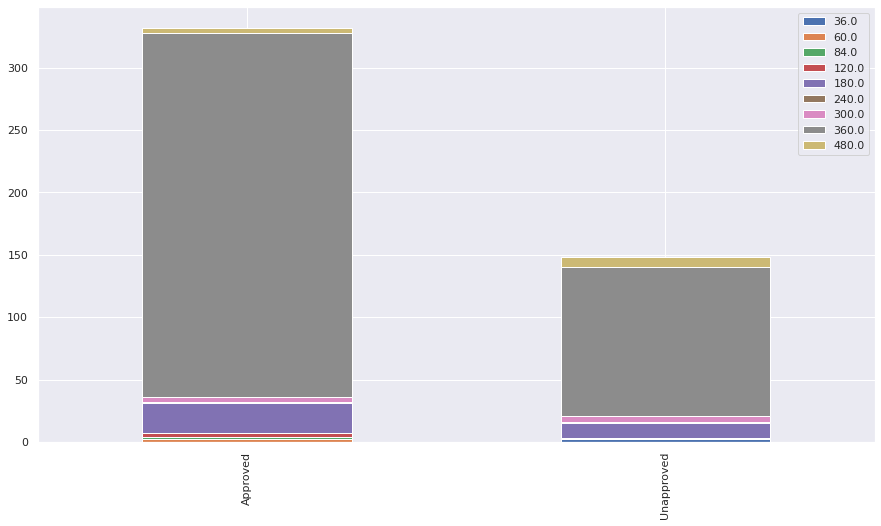

In [206]:
approved_term = df[df['Loan_Status']==1]['Loan_Amount_Term'].value_counts()
unapproved_term = df[df['Loan_Status']==0]['Loan_Amount_Term'].value_counts()
df_concat = pd.DataFrame([approved_term,unapproved_term])
df_concat.index = ['Approved','Unapproved']
df_concat.plot(kind='bar', stacked=True, figsize=(15,8))

In [94]:
# property_dummies = pd.get_dummies(df['Property_Area'], prefix='Property')
# df = pd.concat([df, property_dummies], axis=1)
# df.drop('Property_Area', axis=1, inplace=True)

In [207]:
X = df[['Gender', 'Married', 'ApplicantIncome', 'LoanAmount', 'Credit_History']]
y = df.Loan_Status
X.shape, y.shape

((480, 5), (480,))

## Model Building

#### Il est important de mentionner ici que, afin d'éviter le surapprentissage, la sélection de caractéristiques ne doit être appliquée qu'à l'ensemble d'apprentissage.

In [208]:
df['Loan_Status'].value_counts(normalize = True)

1    0.691667
0    0.308333
Name: Loan_Status, dtype: float64

In [209]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

Dans ce contexte, la stratification signifie que la méthode train_test_split renvoie des sous-ensembles d'entraînement et de test qui ont les mêmes proportions d'étiquettes de classe que l'ensemble de données d'entrée

In [259]:
x_train, x_cv, y_train, y_cv = train_test_split(X,y, stratify=y, test_size = 0.2, random_state = 10)

In [260]:
 y_train.value_counts(normalize=True)

1    0.692708
0    0.307292
Name: Loan_Status, dtype: float64

In [261]:
y_cv.value_counts(normalize=True)

1    0.6875
0    0.3125
Name: Loan_Status, dtype: float64

In [262]:
model = RandomForestClassifier(max_depth=4, random_state=10) 
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [263]:
features = pd.DataFrame()
features['Feature'] = X.columns
features['Importance'] = model.feature_importances_
features.sort_values(by=['Importance'], ascending=False, inplace=True)
features.set_index('Feature', inplace=True)

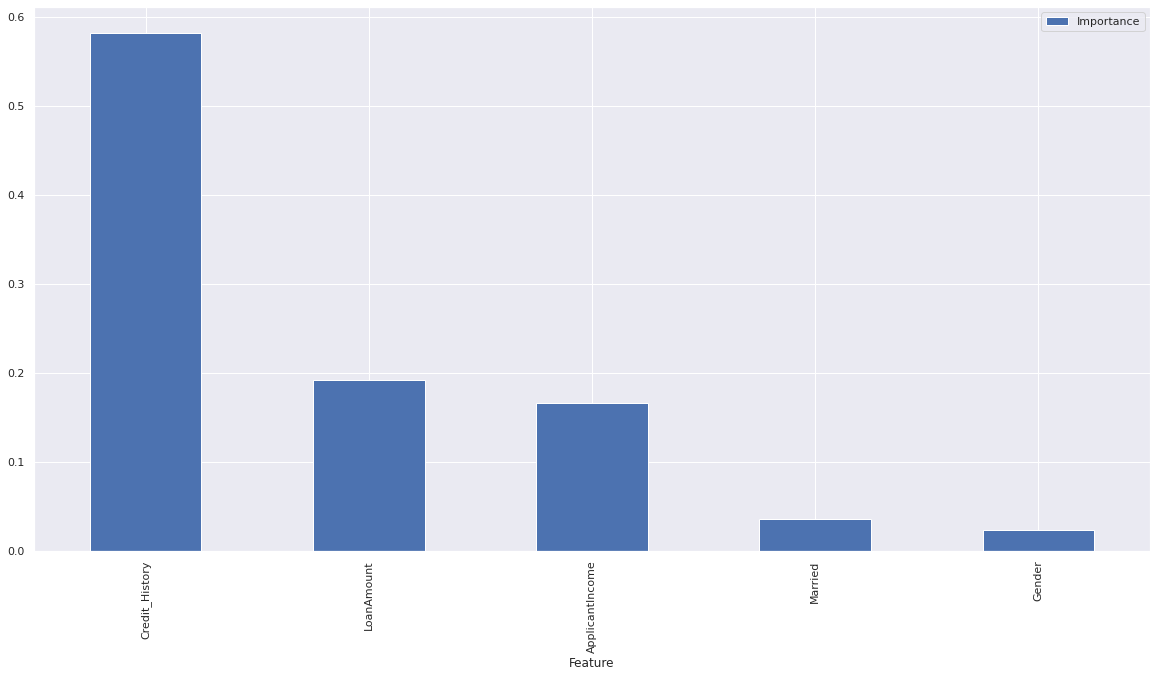

In [264]:
features.plot(kind='bar', figsize=(20, 10))

In [265]:
model.feature_importances_

array([0.0235711 , 0.03548883, 0.16648872, 0.19221243, 0.58223892])

In [266]:
model1 = LGBMClassifier(max_depth =4, random_state=10)
model1.fit(x_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=4,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=10, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

En utilisant les importances des caractéristiques calculées à partir de l'ensemble de données d'apprentissage, nous enveloppons ensuite le modèle dans une instance SelectFromModel. Nous l'utilisons pour sélectionner des caractéristiques sur l'ensemble de données d'apprentissage, former un modèle à partir du sous-ensemble de caractéristiques sélectionné, puis évaluer le modèle sur l'ensemble de test, soumis au même schéma de sélection de caractéristiques.

In [267]:
# Fit model using each importance as a threshold
thresholds = np.sort(model.feature_importances_)
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(x_train)
	# train model
	selection_model = RandomForestClassifier(max_depth=4, random_state=10)
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(x_cv)
	y_pred = selection_model.predict(select_X_test)
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(y_cv, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.024, n=5, Accuracy: 80.21%
Thresh=0.035, n=4, Accuracy: 80.21%
Thresh=0.166, n=3, Accuracy: 79.17%
Thresh=0.192, n=2, Accuracy: 79.17%
Thresh=0.582, n=1, Accuracy: 80.21%


In [268]:
#### Train score
pred_train = model.predict(x_train)
round(accuracy_score(y_train,pred_train),4)

0.8229

In [269]:
#### Train score
pred_train1 = model1.predict(x_train)
round(accuracy_score(y_train,pred_train1),4)

0.8542

In [270]:
### Validation  score
def evaluate(model, test_features,testt_labels):
  pred_cv = model.predict(x_cv)
  print('Model Performance')
  print('Accuracy = {:0.4f}%.'.format(accuracy_score(y_cv,pred_cv)))
  return round(accuracy_score(y_cv,pred_cv),4)

In [271]:
evaluate(model,x_cv,y_cv)

Model Performance
Accuracy = 0.8021%.


0.8021

In [272]:
evaluate(model1,x_cv,y_cv)

Model Performance
Accuracy = 0.7917%.


0.7917

In [273]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 10, scoring=scoring)
    return round(np.mean(xval),4)

In [274]:
compute_score(model,X,y)

0.8021

In [275]:
compute_score(model1,X,y)

0.7688

Check for Overfitting  : Print the score on train and test set




In [276]:
print('Training set score for Random:{:.4f}'.format(model.score(x_train,y_train)))

print('Validation set score:{:.4f}'.format(model.score(x_cv,y_cv)))

Training set score for Random:0.8229
Validation set score:0.8021


the training and validation set accuracy are quite comparable.So we cannot say there is overfittting

In [277]:
print('Training set score for Lightgbm:{:.4f}'.format(model1.score(x_train,y_train)))

print('Validation set score:{:.4f}'.format(model1.score(x_cv,y_cv)))

Training set score for Lightgbm:0.8542
Validation set score:0.7917


In [278]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 10,
 'verbose': 0,
 'warm_start': False}


### Hyperparamter Tuning:

In [279]:
param_grid = {'n_estimators': [10, 20, 30, 40, 50, 60,70],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [4,5,6,7,8],
               'min_samples_split': [2, 5, 10],
               'criterion' :['gini', 'entropy'],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True,False]}

In [280]:
# Use gridsearch for best hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier(random_state=10)

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter =100, cv = 5, verbose=2, random_state=10, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 294 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   27.4s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [281]:
rf_random.best_params_,rf_random.best_score_

({'bootstrap': True,
  'criterion': 'gini',
  'max_depth': 7,
  'max_features': 'auto',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 50},
 0.833356117566644)

In [282]:
rf_model = RandomForestClassifier(bootstrap=True,criterion='gini',max_depth=7,max_features='auto',min_samples_leaf=1,
                                  min_samples_split=2,n_estimators=50,random_state=10)
rf_model.fit(x_train,y_train)

#################################################
rf_accuracy = evaluate(rf_model, x_cv, y_cv)

base_model_accuracy= evaluate(model,x_cv,y_cv)

print('Improvement of {:0.2f}%.'.format( 100 * (rf_accuracy - base_model_accuracy) / base_model_accuracy))

Model Performance
Accuracy = 0.7708%.
Model Performance
Accuracy = 0.8021%.
Improvement of -3.90%.


# Saving the Model

In [285]:
 import pickle 
pickle_out = open("classifier.pkl", mode = "wb") 
pickle.dump(model, pickle_out) 
pickle_out.close()